In [2]:
import re
import random
import pandas as pd
import hashlib

In [3]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [4]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Lost in a Good Book,26.992277,1.349614,20
Network Mapping,58.481622,2.784839,21
Azure AI Search,84.633955,6.045282,14
Taxes,502.559000,50.255900,10
Finance Junk,621.896113,77.737014,8
sklearn,628.447579,125.689516,5
PEP 8,654.601602,22.572469,29
AKS,690.608735,138.121747,5
WSL + Kali Linux,829.497288,24.396979,34
Open Source/GitHub,837.508591,36.413417,23


# Histogram

32914.24


<Axes: >

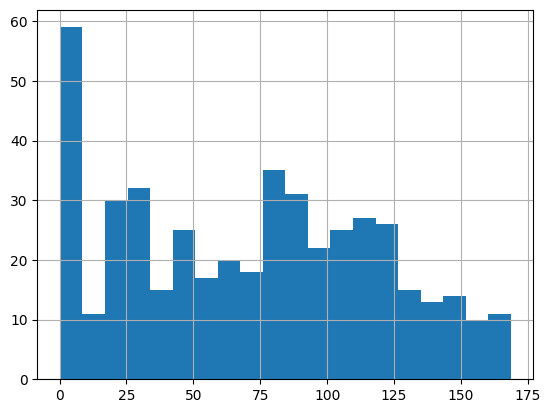

In [5]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [8]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Focus on one header

In [9]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [10]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [11]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Headers with greatest age sum first

In [12]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [13]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [19]:
n=4
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
existing_cards.head(10)

remake_card_document(existing_cards=existing_cards)

Cards found: 456


## Age max

In [15]:
# n=6
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


Cards found: 456


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Diffusers Library,"Forward and Reverse Processes\nIn diffusion, t...",c7dc50c205e26c29be652a67ea7a973e,-168.643901,158.173583,-168.643901,2056.256575,0.759954,0,0
2,Diffusers Library,Text-Guided Image-to-Image Translation: Adapt ...,02e087e5dd26cacf7bbd59b834d03a4f,-165.824624,158.173583,-168.643901,2056.256575,0.759954,1,0
3,Diffusers Library,ELBO (Evidence Lower Bound)\nA loss function t...,3c08814aea7ad722d8959f3c1c6ab2f7,-164.312289,158.173583,-168.643901,2056.256575,0.759954,2,0
5,Diffusers Library,Stochastic Differential Equations (SDEs)\nThes...,156a34280c42128b66ec481fa994ea63,-162.399601,158.173583,-168.643901,2056.256575,0.759954,3,0
7,Diffusers Library,Markov Chain\nA sequence of random variables w...,781ed0d08bf26f44ed0547c4dd21009c,-161.416124,158.173583,-168.643901,2056.256575,0.759954,4,0
9,Diffusers Library,Classifier-Free Guidance\nA technique allowing...,7db77ec1919c8fa6b34c2594b0ec50cb,-160.316985,158.173583,-168.643901,2056.256575,0.759954,5,0
1,MS Identity Platform,The parties in an authentication flow use bear...,0104d2a194fbb32b4288eca1293504c9,-166.600348,156.545110,-166.600348,1095.815770,0.323296,0,0
4,MS Identity Platform,Authorization server - The Microsoft identity ...,a97445a5661ae54e36d4b6479e48e6da,-165.076533,156.545110,-166.600348,1095.815770,0.323296,1,0
11,MS Identity Platform,OAuth versus OpenID Connect: The platform uses...,69f4a149f2ed2a85967e6eec1dbe5f2b,-158.766555,156.545110,-166.600348,1095.815770,0.323296,2,0
15,MS Identity Platform,Resource owner - The resource owner in an auth...,f2fdca585a326c43df53333f7233874b,-157.786430,156.545110,-166.600348,1095.815770,0.323296,3,0


## Age Mean

In [16]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [17]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Diffusers Library,"Forward and Reverse Processes\nIn diffusion, t...",c7dc50c205e26c29be652a67ea7a973e,-168.643901,158.173583,-168.643901,2056.256575,0.759954,0,0
2,Diffusers Library,Text-Guided Image-to-Image Translation: Adapt ...,02e087e5dd26cacf7bbd59b834d03a4f,-165.824624,158.173583,-168.643901,2056.256575,0.759954,1,0
3,Diffusers Library,ELBO (Evidence Lower Bound)\nA loss function t...,3c08814aea7ad722d8959f3c1c6ab2f7,-164.312289,158.173583,-168.643901,2056.256575,0.759954,2,0
5,Diffusers Library,Stochastic Differential Equations (SDEs)\nThes...,156a34280c42128b66ec481fa994ea63,-162.399601,158.173583,-168.643901,2056.256575,0.759954,3,0
7,Diffusers Library,Markov Chain\nA sequence of random variables w...,781ed0d08bf26f44ed0547c4dd21009c,-161.416124,158.173583,-168.643901,2056.256575,0.759954,4,0
9,Diffusers Library,Classifier-Free Guidance\nA technique allowing...,7db77ec1919c8fa6b34c2594b0ec50cb,-160.316985,158.173583,-168.643901,2056.256575,0.759954,5,0
1,MS Identity Platform,The parties in an authentication flow use bear...,0104d2a194fbb32b4288eca1293504c9,-166.600348,156.545110,-166.600348,1095.815770,0.323296,0,0
4,MS Identity Platform,Authorization server - The Microsoft identity ...,a97445a5661ae54e36d4b6479e48e6da,-165.076533,156.545110,-166.600348,1095.815770,0.323296,1,0
11,MS Identity Platform,OAuth versus OpenID Connect: The platform uses...,69f4a149f2ed2a85967e6eec1dbe5f2b,-158.766555,156.545110,-166.600348,1095.815770,0.323296,2,0
15,MS Identity Platform,Resource owner - The resource owner in an auth...,f2fdca585a326c43df53333f7233874b,-157.786430,156.545110,-166.600348,1095.815770,0.323296,3,0


In [18]:
existing_cards.head(10)['age'].sum()

np.float64(-1631.143391774689)